In [16]:
from fastai.vision.all import *
from sklearn.manifold import TSNE

def label_func(f):
    return parent_label(f)


class TripletImage(fastuple):
    def show(self, loss=None, pred=None, p=None, ctx=None, **kwargs): 
        if len(self) > 3:
                img1,img2,img3,similarity = self
        else:
            img1,img2,img3 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            if img3.size != img1.size: img3 = img3.resize(img1.size)
            t1,t2,t3 = tensor(img1),tensor(img2), tensor(img3)
            t1,t2,t3 = t1.permute(2,0,1),t2.permute(2,0,1),t3.permute(2,0,1)
        else: t1,t2,t3 = img1,img2,img3
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        if loss == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=similarity, ctx=ctx, **kwargs)
        elif pred == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{loss:.2f}", ctx=ctx, **kwargs)
        return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{pred}/{similarity} {loss:.2f} / {p:.2f}", ctx=ctx, **kwargs)

    
    
class TripletTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,f3,cls = self.valid.get(f, self._draw(f,0))
        img1,img2,img3 = PILImage.create(f),PILImage.create(f2),PILImage.create(f3)
        return TripletImage(img1, img2, img3, int(cls))
    
    def _draw(self, f, split=0):
        cls1 = label_func(f)
        cls2 = random.choice(L(l for l in labels if l != cls1))
        while len(self.splbl2files[split][cls2]) == 0: 
            cls2 = random.choice(L(l for l in labels if l != cls1))
        return random.choice(self.splbl2files[split][cls1]),random.choice(self.splbl2files[split][cls2]),cls1
        

class TripletModel(Module):
    def __init__(self, encoder):
        self.encoder = encoder
    
    def forward(self, x1, x2, x3):
        # anchor positive negative
        ftrs1 = nn.Flatten()(self.encoder(x1))
        ftrs2 = nn.Flatten()(self.encoder(x2))
        ftrs3 = nn.Flatten()(self.encoder(x3))
        return ftrs1, ftrs2, ftrs3
    def forward_one(self, x):
        return nn.Flatten()(self.encoder(x))
    
@typedispatch
def show_batch(x:TripletImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): TripletImage(x[0][i], x[1][i], x[2][i], x[3][i].item()).show(ctx=ctx)
    

def triplet_top_losses(learn, preds=None, max_n=10, n_cols=2):
    if preds == None:
        preds = learn.get_preds(with_loss=True, with_input=True)
    ctxs = get_grid(max_n, nrows=None, ncols=n_cols, figsize=(n_cols*6, max_n//n_cols * 3), title='Triplet Loss')
    dl = learn.dls.valid.enumerate()
    topk = preds[-1].topk(max_n)
    start = time.time()
    for i, ctx in enumerate(ctxs):
        idx = topk[-1][i].item()
        loss = topk[0][i].item()
        dl[idx][1].show(loss=loss, ctx=ctx)

In [17]:
class _Loss(Module):
    reduction: str
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction


class triplet_loss_func(_Loss):
    __constants__ = ['margin', 'p', 'eps', 'swap', 'reduction']
    margin: float
    p: float
    eps: float
    swap: bool

    def __init__(self, margin: float = 1.0, p: float = 2., eps: float = 1e-6, swap: bool = False, size_average=None,
                 reduce=None, reduction: str = 'mean'):
        super(triplet_loss_func, self).__init__(size_average, reduce, reduction)
        self.margin = margin
        self.p = p
        self.eps = eps
        self.swap = swap
    def forward(self, x, *args):
        anchor, positive, negative = x[0], x[1], x[2]
        
        return F.triplet_margin_loss(anchor, positive, negative, margin=self.margin, p=self.p,
                                     eps=self.eps, swap=self.swap, reduction=self.reduction)

In [18]:
path = '/home/katsu/.fastai/data/mnist_png/'
files = get_image_files(path)
labels = list(set(files.map(label_func)))
splits = RandomSplitter(seed=1)(files)

In [19]:
tfm = TripletTransform(files, splits)
valids = [v[0] for k,v in tfm.valid.items()]

In [20]:
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(64), ToTensor], after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
dls.cuda()

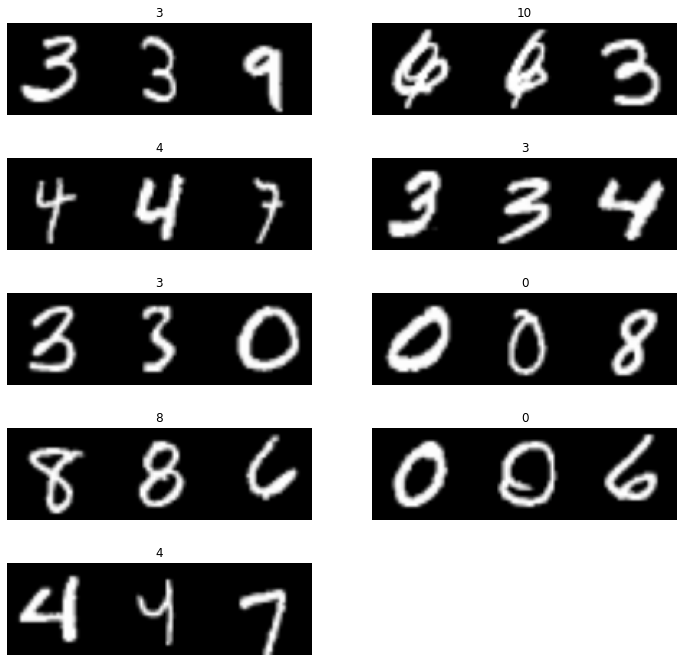

In [21]:
dls.show_batch()

In [22]:
encoder = create_body(vgg16_bn, cut=-2)
model = TripletModel(encoder)

In [23]:
earlyStopping = EarlyStoppingCallback(patience=5)
learn = Learner(dls, model, loss_func=triplet_loss_func(margin=100), cbs=[ShowGraphCallback, SaveModelCallback, earlyStopping])

epoch,train_loss,valid_loss,time
0,4.343359,4.279152,04:12
1,0.638584,0.656903,04:16


Better model found at epoch 0 with valid_loss value: 4.2791523933410645.


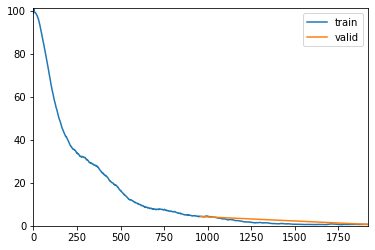

Better model found at epoch 1 with valid_loss value: 0.6569030284881592.


In [24]:

learn.fit_one_cycle(2)

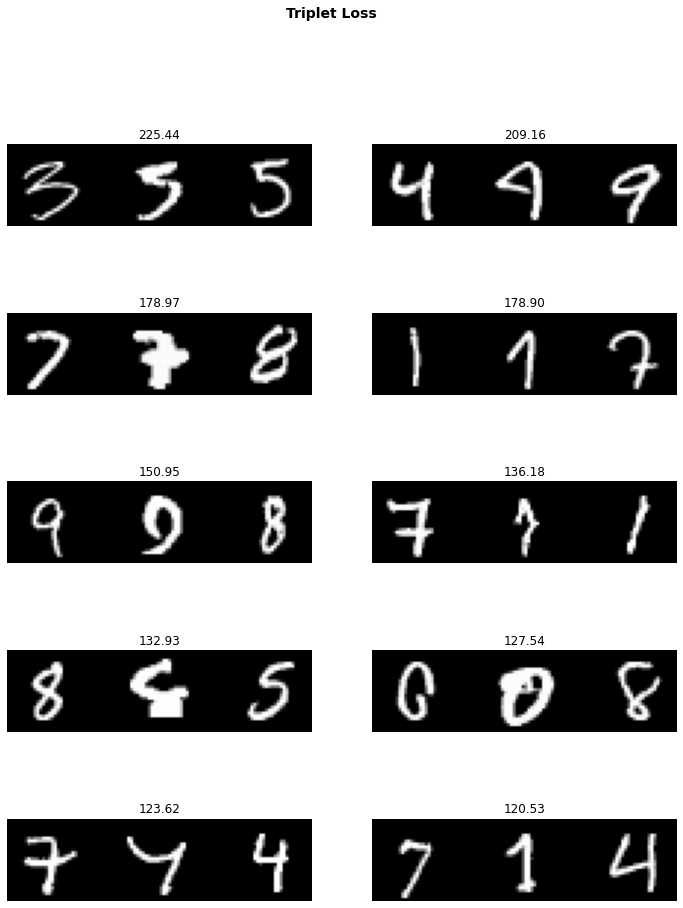

In [25]:
triplet_top_losses(learn)

In [26]:
hooks = Hooks(model.encoder, lambda m,i,o: o)

In [27]:
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
#     print(i)
#     i.show()
    learn.model(i[0], i[1], i[2])
    ftrs = torch.cat((ftrs, nn.Flatten()(hooks.stored[-1])))

In [28]:
tsne = TSNE(n_components=2)

/home/katsu/anaconda3/envs/fa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/katsu/anaconda3/envs/fa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


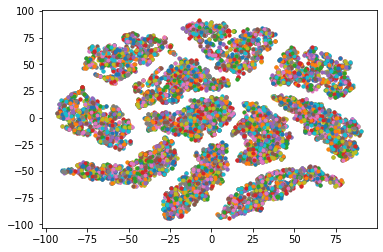

In [29]:
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')